## Introduction

The name of housing unit types are specific of the Italian market, therefore I create a short dictionary with its translation in English:
- Monolocale: studio flat(one-room apartment)
- Bilocale: two-rooms apartment       
- Trilocale: three-rooms apartment       
- Quadrilocale: four-rooms apartment
- Appartamento: flat/apartment (that is from four to more rooms) 
- Attico: attic           
- Villa: house/villa
- Palazzo: building/palace
- Mansarda: mansard        
- Loft: loft apartment       
- Terratetto: this is a typical italian building of the early year of the 20th century. It means "from the ground to the roof"      
- Open space: open space apartment  
- Casale: farmhouse

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns

import math
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import  mean_absolute_error, r2_score, mean_absolute_percentage_error, mean_squared_error

# from xgboost import XGBRegressor 

from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_italia = pd.read_csv('D002_CLEANED_DATASET_RENT_ITALY.csv')

df_italia

,Price,Surface,City,Housing_unit,city_size,macroregion,floor,num_rooms,rent_bracket,surface_bracket
0,8500.0,250.0,Milano,Appartamento,big,north,3.0,6,very high,large
1,1150.0,40.0,Milano,Monolocale,big,north,3.0,1,mid-high,small
2,900.0,51.0,Milano,Bilocale,big,north,3.0,2,mid-low,small
3,1550.0,55.0,Milano,Bilocale,big,north,3.0,2,mid-high,small
4,920.0,45.0,Milano,Bilocale,big,north,3.0,2,mid-low,small
...,...,...,...,...,...,...,...,...,...,...
10662,850.0,65.0,Modena,Mansarda,mid-small,north,4.0,2,mid-low,small
10663,1500.0,140.0,Modena,Attico,mid-small,north,4.0,4,mid-high,mid
10664,600.0,25.0,Modena,Bilocale,mid-small,north,4.0,2,low,very small
10665,850.0,70.0,Modena,Bilocale,mid-small,north,4.0,2,mid-low,mid-small


## Remove outliers and suspicious values

Outliers are removed using the IQR and and some suspicious values are deleted. 
For suspicious values I mean those houses/flats with:
- Price rent < 150, because they are probably daily or weekly rents in B&B, while I am focusing on monthly rents 
- Surface < 20 m2, because they are more likely to be scams since they are too small to be said livable

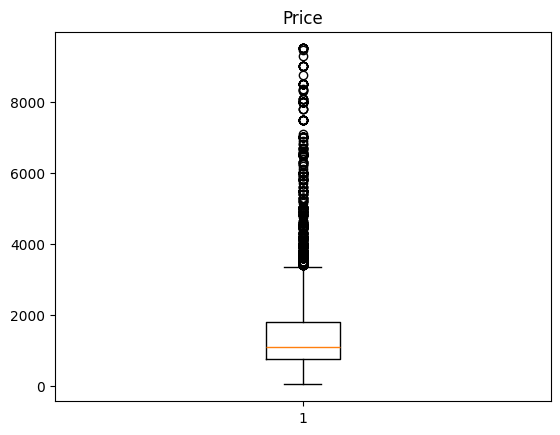

In [3]:
plt.boxplot(df_italia['Price'])
plt.title('Price');

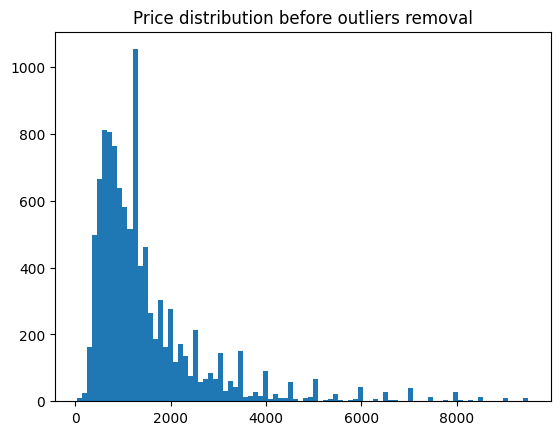

In [4]:
plt.hist(df_italia['Price'], bins = 90)
plt.title('Price distribution before outliers removal');

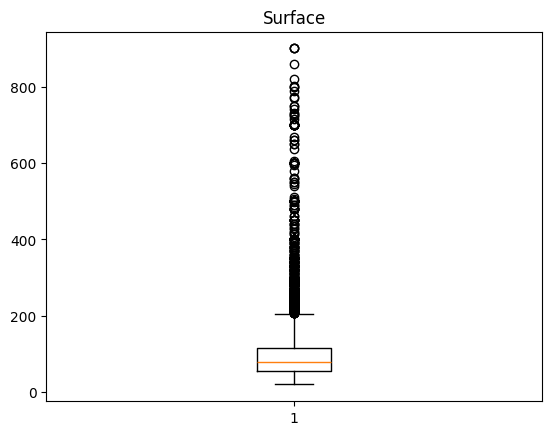

In [5]:
plt.boxplot(df_italia['Surface'])
plt.title('Surface');

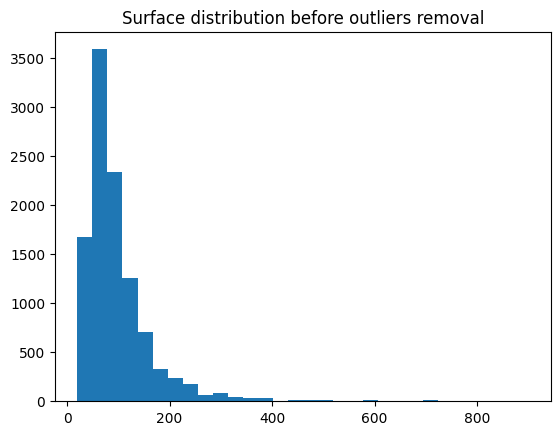

In [6]:
plt.hist(df_italia['Surface'], bins = 30)
plt.title('Surface distribution before outliers removal');

In [7]:
len(df_italia[df_italia['Price']<250]), len(df_italia[df_italia['Surface']<20])

(24, 0)

In [8]:
#Removing suspicious values, that could be scam announcements or daily/weekly rents in B&B
df_italia =df_italia[(df_italia['Surface']>=20) & (df_italia['Price']>=250)]

In [9]:
df_italia.shape

(10643, 10)

In [91]:
def remove_outliers_iqr(df,columns):
    for col in columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df


columns_to_check = ['Price','Surface']
df_cleaned = remove_outliers_iqr(df_italia, columns_to_check)

df_cleaned.head()

,Price,Surface,City,Housing_unit,city_size,macroregion,floor,num_rooms,rent_bracket,surface_bracket
1,1150.0,40.0,Milano,Monolocale,big,north,3.0,1,mid-high,small
2,900.0,51.0,Milano,Bilocale,big,north,3.0,2,mid-low,small
3,1550.0,55.0,Milano,Bilocale,big,north,3.0,2,mid-high,small
4,920.0,45.0,Milano,Bilocale,big,north,3.0,2,mid-low,small
5,2975.0,150.0,Milano,Quadrilocale,big,north,3.0,4,high,mid


In [92]:
# df_cleaned = df_italia.copy()
df_cleaned.shape

(9421, 10)

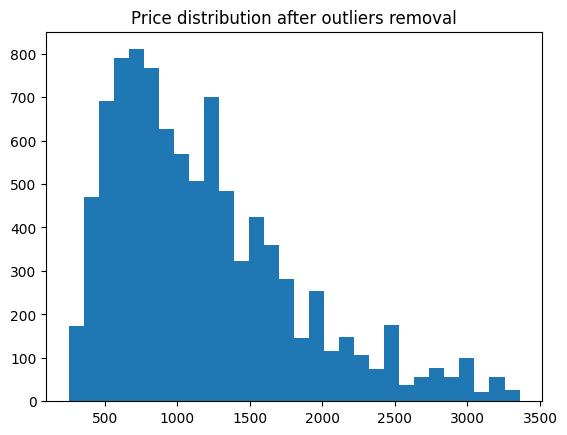

In [93]:
plt.hist(df_cleaned['Price'], bins = 30)
plt.title('Price distribution after outliers removal');

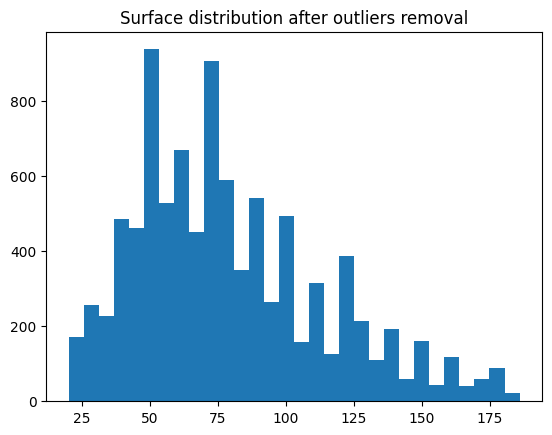

In [94]:
plt.hist(df_cleaned['Surface'], bins = 30)
plt.title('Surface distribution after outliers removal');

# Model Building

## Data preparation

The machine learning algoritms used for model building are Decision Tree, Random Forest, XGBoost and LGBM; the last two are gradient boosting backed algorithms. All of them have a regressor option that was used to predict the rent price.

in particulare, LGBM has a specific procedure for data preparation that require to transform numerical variables into float variables

In [95]:
df_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
Index: 9421 entries, 1 to 10666
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Price            9421 non-null   float64
 1   Surface          9421 non-null   float64
 2   City             9421 non-null   object 
 3   Housing_unit     9421 non-null   object 
 4   city_size        9421 non-null   object 
 5   macroregion      9421 non-null   object 
 6   floor            9420 non-null   float64
 7   num_rooms        9421 non-null   int64  
 8   rent_bracket     9421 non-null   object 
 9   surface_bracket  9421 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 809.6+ KB


In [96]:
df_cleaned.select_dtypes(include='object').columns

Index(['City', 'Housing_unit', 'city_size', 'macroregion', 'rent_bracket',
       'surface_bracket'],
      dtype='object')

In [97]:
df_cleaned.select_dtypes(include=['float64','int64']).columns

Index(['Price', 'Surface', 'floor', 'num_rooms'], dtype='object')

In [98]:
categorical_cols = ['City', 
                    'Housing_unit', 
                    'city_size', 
                    'macroregion', 
                    'rent_bracket',
                    'surface_bracket']

numeric_cols = ['Surface', 
                'floor', 
                'num_rooms']

features = categorical_cols + numeric_cols

target = ['Price']

In [99]:
df_cleaned[categorical_cols] = df_cleaned[categorical_cols].astype('category')

In [100]:
X = df_cleaned.drop(columns = 'Price', axis = 1)
Y = df_cleaned['Price']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train.shape, X_test.shape, X.shape

((8478, 9), (943, 9), (9421, 9))

In [101]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, train_size=0.9, random_state = 42)
X_train.shape, X_val.shape, X.shape

((7630, 9), (848, 9), (9421, 9))

In [102]:
X_train.shape, X_val.shape, X_test.shape, X.shape

((7630, 9), (848, 9), (943, 9), (9421, 9))

## LGBM

In [103]:
lgbm = LGBMRegressor()

param_grid ={
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1]
}


grid_search = GridSearchCV(lgbm, param_grid, cv=5, scoring = 'neg_mean_squared_error') 

grid_search.fit(X_train , Y_train )

print(grid_search.best_params_)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 223
[LightGBM] [Info] Number of data points in the train set: 6104, number of used features: 9
[LightGBM] [Info] Start training from score 1185.545872
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 227
[LightGBM] [Info] Number of data points in the train set: 6104, number of used features: 9
[LightGBM] [Info] Start training from score 1184.474771
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

In [ ]:
X_train.select_dtypes(include='object').columns

In [115]:
# With the LGBM algorithm numerical variables need to be trasnformed into float variables
# X_train = X_train.astype(float)
# X_val = X_val.astype(float)
# Y_train = Y_train.astype(float)
# # Y_val = Y_val.astype(float)

params_2 ={'learning_rate': 0.1, 'n_estimators': 50}
params_1 =  {'n_estimators': 150 ,'learning_rate': 0.1}

num  = 2

lgbm = LGBMRegressor(**params_2)
lgbm.fit(X_train , Y_train )

y_train_pred = lgbm.predict(X_train)

mae = round( mean_absolute_error(Y_train,y_train_pred), 2)
mse = round(mean_squared_error(Y_train,y_train_pred), 2)
mape = round(mean_absolute_percentage_error(Y_train,y_train_pred)*100,2)
r2 = round(r2_score(Y_train,y_train_pred)*100,2)
rmse = round(math.sqrt(mse), 2)


print(f"MAE is: {mae}")
print(f"MSE is: {mse}")
print(f"MAPE is: {mape}")
print(f"R2 SCORE is: {r2}")
print(f"RMSE is: {rmse}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 7630, number of used features: 9
[LightGBM] [Info] Start training from score 1181.482831
MAE is: 138.6
MSE is: 37234.34
MAPE is: 11.41
R2 SCORE is: 91.06
RMSE is: 192.96


In [ ]:
# df_metrics = pd.DataFrame(columns=['Algorithm', 'MAE €', 'MSE €', 'RMSE €', 'MAPE %',   'R2 Score %' ])


In [116]:

# df_metrics = pd.DataFrame(columns=['Algorithm', 'MAE €', 'MSE €', 'RMSE €', 'MAPE %',   'R2 Score %' ])

df_metrics.loc[len(df_metrics)] = {'Algorithm':f'LGBM Regressor params_{num} no OUTLIERS TRAIN', 
                                        'MAE €':mae, 
                                        'MSE €': mse,  
                                        'RMSE €': rmse, 
                                        'MAPE %': mape, 
                                        'R2 Score %': r2 }

df_metrics

,Algorithm,MAE €,MSE €,RMSE €,MAPE %,R2 Score %
0,LGBM Regressor params_1 no OUTLIERS TRAIN,153.74,47273.93,217.43,12.36,88.00
1,LGBM Regressor params_1 no OUTLIERS VAL,153.74,47273.93,217.43,12.36,88.00
2,LGBM Regressor params_2 no OUTLIERS TRAIN,138.60,37234.34,192.96,11.41,91.06


In [117]:
y_pred = lgbm.predict(X_val)

mae = round(mean_absolute_error(Y_val,y_pred), 2)
mse = round(mean_squared_error(Y_val,y_pred), 2)
mape = round(mean_absolute_percentage_error(Y_val,y_pred)*100,2)
r2 = round(r2_score(Y_val,y_pred), 2)*100
rmse =round( math.sqrt(mse), 2)


print(f"MAE is: {mae}")
print(f"MSE is: {mse}")
print(f"MAPE is: {mape}")
print(f"R2 SCORE is: {r2}")
print(f"RMSE is: {rmse}")


MAE is: 152.39
MSE is: 45912.68
MAPE is: 12.18
R2 SCORE is: 88.0
RMSE is: 214.27


In [118]:
df_metrics.loc[len(df_metrics)] = {
    'Algorithm': f'LGBM Regressor params_{num} no OUTLIERS VAL',
    'MAE €': mae,
    'MSE €': mse,
    'RMSE €': rmse,
    'MAPE %': mape,
    'R2 Score %': r2
}

In [119]:
df_metrics


,Algorithm,MAE €,MSE €,RMSE €,MAPE %,R2 Score %
0,LGBM Regressor params_1 no OUTLIERS TRAIN,153.74,47273.93,217.43,12.36,88.00
1,LGBM Regressor params_1 no OUTLIERS VAL,153.74,47273.93,217.43,12.36,88.00
2,LGBM Regressor params_2 no OUTLIERS TRAIN,138.60,37234.34,192.96,11.41,91.06
3,LGBM Regressor params_2 no OUTLIERS VAL,152.39,45912.68,214.27,12.18,88.00


In [ ]:
df_metrics_outliers

In [120]:
df_metrics_w_outliers = df_metrics.copy()

In [121]:
df_metrics_outliers

,Algorithm,MAE €,MSE €,RMSE €,MAPE %,R2 Score %
0,LGBM Regressor params_1 TRAIN,188.61,94206.71,306.93,11.99,94.16
1,LGBM Regressor params_1 VAL,227.60,169990.52,412.30,12.92,90.00
2,LGBM Regressor params_2 TRAIN,203.54,114836.86,338.88,12.65,92.88
4,LGBM Regressor params_2 VAL,223.28,164476.75,405.56,12.77,90.00


In [122]:
df_metrics_w_outliers

,Algorithm,MAE €,MSE €,RMSE €,MAPE %,R2 Score %
0,LGBM Regressor params_1 no OUTLIERS TRAIN,153.74,47273.93,217.43,12.36,88.00
1,LGBM Regressor params_1 no OUTLIERS VAL,153.74,47273.93,217.43,12.36,88.00
2,LGBM Regressor params_2 no OUTLIERS TRAIN,138.60,37234.34,192.96,11.41,91.06
3,LGBM Regressor params_2 no OUTLIERS VAL,152.39,45912.68,214.27,12.18,88.00
